## Parameter Sweep over Line Lenghts

In [1]:
; cd ..

/Users/rhenriquez/Github_Projects/InverterDynamicLinesModels


In [2]:
] activate

 Activating environment at `~/Github_Projects/InverterDynamicLinesModels/Project.toml`


In [3]:
] instantiate

In [4]:
using OrdinaryDiffEq #Gets the solvers
using Plots
include(joinpath(pwd(), "InverterDynamicLinesModels", "InverterDynamicLinesModels.jl"))

In [5]:
using PowerSystems

In [6]:
# Load Data with PF solution from file
omib_sys = System(joinpath(pwd(), "data", "OMIB_inverter.json"));

┌ Info: Loaded time series from storage file existing=OMIB_inverter_time_series_storage.h5 new=/var/folders/fz/6cnhcl5n2dggz6f6c_l54g740000gn/T/jl_VxFfpA
└ @ InfrastructureSystems /Users/rhenriquez/.julia/packages/InfrastructureSystems/uydla/src/hdf5_time_series_storage.jl:72
┌ Warning: There are no Generator Components in the System
└ @ PowerSystems /Users/rhenriquez/.julia/packages/PowerSystems/Ihfxp/src/utils/IO/system_checks.jl:56
┌ Warning: There are no ElectricLoad Components in the System
└ @ PowerSystems /Users/rhenriquez/.julia/packages/PowerSystems/Ihfxp/src/utils/IO/system_checks.jl:56


# Parameter Sweep of Line Length

## Kundur Overhead line: 230kV
`r = 50.0 mΩ/km `
`x_l = 0.488 Ω/km`
`y_c = j3.371 μS/km`

In [7]:
_r = 50e-3
_x = 0.488
_yc = 1im * 3.371e-6
Sb = 100
Vb = 230
Zb = Vb^2/Sb;

In [8]:
## Function that updates Line Parameters
function line_parameters_equiv(l::Real)
    _z = _r + 1im*_x
    γ = sqrt(_z * _yc)
    _Z = (_r + 1im*_x) * l * (sinh(γ * l) / (γ * l))
    _Yc = (_yc * l)/2 * (tanh(γ * l / 2) / (γ * l / 2))
    _Z_pu = _Z / Zb
    _Yc_pu = _Yc * Zb
    _lg = imag(_Z_pu) * (1/2)
    _rg = real(_Z_pu) * (1/2)
    _cg = imag(_Yc_pu) * 2
    _gg = real(_Yc_pu) * 2
    return (_lg, _rg, _cg, _gg)
end

line_parameters_equiv (generic function with 1 method)

In [9]:
# Sweep over the length: 100 km to 400 km every 5km
length_range = range(100, 400, step=5)

100:5:400

In [10]:
# See parameters for 100km : (l, r, c, g)
line_parameters_equiv(100)

(0.04599972957574926, 0.004700015335324309, 0.17857076080070755, 2.5129972421186454e-5)

# Update R,L,C with line length

### Full VSM model

In [11]:
#Instantiate Parameters for VSM model
parameter_mapping = instantiate_parameters(VInertia, omib_sys)
M_vsm = instantiate_model(VInertia, DynamicLines, omib_sys)
u0 = M_vsm(parameter_mapping) # works as a test, not really necessary to call
jac_exp_vsm = get_jacobian_function(VInertia, DynamicLines);
fjac_vsm = eval(jac_exp_vsm);
jac_vsm = instantiate_jacobian(M_vsm, fjac_vsm)
ss_vsm = instantiate_small_signal(M_vsm, jac_vsm)
ss_vsm(M_vsm, jac_vsm);

In [12]:
#Update P_ref to 1.0
parameter_values = [x.second for x in parameter_mapping];
parameter_values[10] = 1.0

1.0

In [13]:
N = length(length_range)
real_max_eig_vsm = Vector{Float64}(undef, N)
voltage_vsm = Vector{Float64}(undef, N)
all_eigenvalues_vsm = Matrix{Complex}(undef, N, 19)
p_fact_vsm = Array{Float64}(undef, (N, 19, 19))
for (j,lenval) in enumerate(length_range)
    p_vals = line_parameters_equiv(lenval)
    parameter_values[4] = p_vals[1]
    parameter_values[5] = p_vals[2]
    parameter_values[6] = p_vals[3]
    parameter_values[7] = p_vals[4]
    M_vsm(parameter_values)
    jac_vsm(M_vsm)
    ss_vsm(M_vsm, jac_vsm)
    eig = ss_vsm.eigen_vals[end]
    real_max_eig_vsm[j] = real(eig)
    voltage_vsm[j] = real(ss_vsm.eigen_vals[end-2])
    all_eigenvalues_vsm[j, :] = ss_vsm.eigen_vals
    p_fact_vsm[j, :, :] = round.(ss_vsm.participation_factors, digits=4)
end

### VSM model with Static Lines

In [14]:
#Instantiate Parameters for VSM model
parameter_mapping = instantiate_parameters(VInertia, omib_sys)
M_vsm = instantiate_model(VInertia, StaticLines, omib_sys)
u0 = M_vsm(parameter_mapping) # works as a test, not really necessary to call
jac_exp_vsm = get_jacobian_function(VInertia, StaticLines);
fjac_vsm = eval(jac_exp_vsm);
jac_vsm = instantiate_jacobian(M_vsm, fjac_vsm)
ss_vsm = instantiate_small_signal(M_vsm, jac_vsm)
ss_vsm(M_vsm, jac_vsm);

In [15]:
parameter_values = [x.second for x in parameter_mapping];
parameter_values[10] = 1.0

1.0

In [16]:
N = length(length_range)
real_max_eig_vsm_static = Vector{Float64}(undef, N)
all_eigenvalues_vsm_static = Matrix{Complex}(undef, N, 13)
p_fact_static = Array{Float64}(undef, (N, 13, 13))
for (j,lenval) in enumerate(length_range)
    p_vals = line_parameters_equiv(lenval)
    parameter_values[4] = p_vals[1]
    parameter_values[5] = p_vals[2]
    parameter_values[6] = p_vals[3]
    parameter_values[7] = p_vals[4]
    M_vsm(parameter_values)
    jac_vsm(M_vsm)
    ss_vsm(M_vsm, jac_vsm)
    eig = ss_vsm.eigen_vals[end]
    real_max_eig_vsm_static[j] = real(eig)
    all_eigenvalues_vsm_static[j, :] = ss_vsm.eigen_vals
    p_fact_static[j, :, :] = round.(ss_vsm.participation_factors, digits=4)
end

### VSM model with Filter+Lines algebraic

In [17]:
#Instantiate Parameters for VSM model
parameter_mapping = instantiate_parameters(VInertia, omib_sys)
M_vsm = instantiate_model(VInertia, ACStatic, omib_sys)
u0 = M_vsm(parameter_mapping) # works as a test, not really necessary to call
jac_exp_vsm = get_jacobian_function(VInertia, ACStatic);
fjac_vsm = eval(jac_exp_vsm);
jac_vsm = instantiate_jacobian(M_vsm, fjac_vsm)
ss_vsm = instantiate_small_signal(M_vsm, jac_vsm)
ss_vsm(M_vsm, jac_vsm);

In [18]:
parameter_values = [x.second for x in parameter_mapping];
parameter_values[10] = 1.0

1.0

In [19]:
N = length(length_range)
real_max_eig_vsm_acstatic = Vector{Float64}(undef, N) 
all_eigenvalues_vsm_acstatic = Matrix{Complex}(undef, N, 7)
p_fact_acstatic = Array{Float64}(undef, (N, 7, 7))
for (j,lenval) in enumerate(length_range)
    p_vals = line_parameters_equiv(lenval)
    parameter_values[4] = p_vals[1]
    parameter_values[5] = p_vals[2]
    parameter_values[6] = p_vals[3]
    parameter_values[7] = p_vals[4]
    M_vsm(parameter_values)
    jac_vsm(M_vsm)
    ss_vsm(M_vsm, jac_vsm)
    eig = ss_vsm.eigen_vals[end]
    real_max_eig_vsm_acstatic[j] = real(eig)
    all_eigenvalues_vsm_acstatic[j, :] = ss_vsm.eigen_vals
    p_fact_acstatic[j, :, :] = round.(ss_vsm.participation_factors, digits=4)
    #print(lenval)
    #print("\n")
    #print(M_vsm.u0[3])
    #print("\n")
end

The following indexing removes the eigenvalues associated with the lines and filters for other models to only compare between inverter associated eigenvalues

In [20]:
index = trues(19)
index[end-1:end] .= false
index[9:12] .= false;
index[1:6] .= false
sum(index)
index2 = trues(19)
index2[end-1:end] .= false
index2[9:10] .= false;
index2[13:14] .= false;
index2[1:6] .= false;

In [21]:
index_st = trues(13)
index_st[1:6] .= false;
sum(index_st);

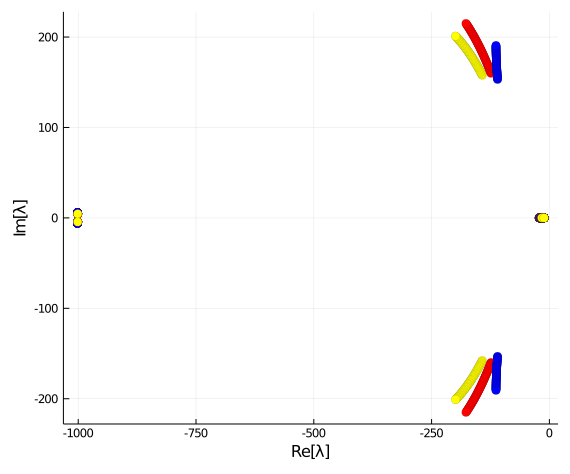

In [34]:
plt = scatter(real.(all_eigenvalues_vsm_acstatic[1,:]), imag.(all_eigenvalues_vsm_acstatic[1,:]), marker =  5,legend = :none, color=:yellow, markerstrokewidth = 0.1, label="a")
scatter!(real.(all_eigenvalues_vsm[1,index]), imag.(all_eigenvalues_vsm[1,index]), marker = 5,legend = :none, color=:blue, markerstrokewidth = 0.1)
scatter!(real.(all_eigenvalues_vsm_static[1,index_st]), imag.(all_eigenvalues_vsm_static[1,index_st]), marker =  5,legend = :none, color=:red, markerstrokewidth = 0.1)
for i=2:50
    scatter!(real.(all_eigenvalues_vsm[i,index]), imag.(all_eigenvalues_vsm[i,index]), marker = 5,legend = :none, color=:blue, markerstrokewidth = 0.1)
    scatter!(real.(all_eigenvalues_vsm_static[i,index_st]), imag.(all_eigenvalues_vsm_static[i,index_st]), marker =  5,legend = :none, color=:red, markerstrokewidth = 0.1)
    scatter!(real.(all_eigenvalues_vsm_acstatic[i,:]), imag.(all_eigenvalues_vsm_acstatic[i,:]), marker = 5,legend = :none, color=:yellow, markerstrokewidth = 0.1)
end
plot!(size=(3*190,3*158.1))
plot!(xlabel="Re[λ]")
plot!(ylabel="Im[λ]")
plt
#Yellow for ACStatic, Red for StaticLines and Blue for DynamicLines